# UNIVERSIDAD HEMISFERIOS

## Modulo Aprendizaje Automatico

## Integrantes

INTEGRANTES : DANNY DIAZ | DANIEL ORTEGA | RUBEN TOCAIN

# Introducción

Este informe presenta el desarrollo de un modelo basado en Máquinas de Soporte Vectorial (SVM) para diagnosticar el estado de una caja de engranajes a partir de señales de vibración. Las condiciones a identificar son: (1) Normal, (2) Picadura en el piñón y (3) Rotura del diente al 100%. Se emplean señales recolectadas bajo diversas combinaciones de velocidad y carga, y se extraen características tanto en el dominio del tiempo como en el tiempo-frecuencia. Finalmente, se ajustan los hiperparámetros del modelo mediante validación cruzada para optimizar su rendimiento diagnóstico.

# Dependencias

In [1]:
from scipy.io import loadmat
import pywt
import numpy as np
from scipy.stats import skew, kurtosis, sem, differential_entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
file_path = 'D:/GitHub/101MachineLearning/000_data/master/Base_Datos_matlab.mat'

# 1. Cargar y preprocesamiento de la Base de Datos

In [6]:
data = loadmat(file_path)

In [7]:
# Procesamiento de la base de datos para la extracción de características en el dominio del tiempo y tiempo-frecuencia:
# 
def wavelet_features(signal):
    power = []
    for wavelet in ['db7','sym3','coif4','bior3.5','rbio3.5']:
        wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric')
        power.extend([np.square(node.data).mean() for node in wp.get_level(5, 'freq')])        
    return power


def compute_features(signal):
    mean = np.mean(signal)
    var = np.var(signal)
    sk = skew(signal)
    kur = kurtosis(signal)
    rms = np.sqrt(np.mean(signal**2))
    max_val = np.max(signal)
    min_val = np.min(signal)
    std_error = sem(signal)
    ent = differential_entropy(signal)
    std = np.std(signal)
    power = wavelet_features(signal)
    return [mean, var, sk, kur, rms, max_val, min_val, std_error, ent, std, *power]


X_list = []
y_list = []
for condition in [0, 3, 11]:
    for power in range(3):
        for speed in range(5):
            for repetition in range(10):
                signal = data['CXX'][0][condition][0][power][speed][repetition][:,1]
                features = compute_features(signal)
                X_list.append(features)
                y_list.append(condition)
X = np.array(X_list)
y = np.array(y_list)


# Creación de los subconjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)  

In [8]:
X.shape

(450, 170)

# 2. Escalar las caracteristicas
El escalado es importante, especialmente para modelos como SVM que son sensibles a la escala de las características.

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# 3. Selección de Características
Seleccionaremos el 50% de las características usando un método supervisado para simplificar el modelo y potencialmente mejorar el rendimiento.

In [12]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo base (por ejemplo, SVM)
svm = SVC(kernel='linear')  # Usamos un kernel lineal para la importancia de las características

# Crear el selector RFE para seleccionar el 50% de las características
n_features_to_select = int(X_train_scaled.shape[1] * 0.5)
rfe = RFE(estimator=svm, n_features_to_select=n_features_to_select)

# Ajustar el selector a los datos de entrenamiento
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)

# Transformar el conjunto de prueba
X_test_selected = rfe.transform(X_test_scaled)

# Ver las características seleccionadas
print(f"Total de características seleccionadas: {X_train_selected.shape[1]}")

Total de características seleccionadas: 85


In [13]:
X_train_scaled.shape, X_train_selected.shape

((315, 170), (315, 85))

# 4. Seleccionar los Hiperparámetros del Modelo SVM
Usaremos GridSearchCV para encontrar los mejores hiperparámetros para nuestro modelo SVM.

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Definir el modelo
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],             # Varios valores para la penalización
    'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],  # Diferentes valores de gamma
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']   # Variación de kernel
}

# Calcular el número total de combinaciones
num_combinations = len(param_grid['C']) * len(param_grid['gamma']) * len(param_grid['kernel'])
print(f"Total de combinaciones a probar: {num_combinations}")

# Definir la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5)

# Configurar GridSearchCV con más información en verbose
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='accuracy', verbose=3, n_jobs=-1)

# Ajustar el modelo al conjunto de datos de entrenamiento
grid_search.fit(X_train_selected, y_train)

# Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_
# Evaluar el modelo en el conjunto de prueba
accuracy_test = best_svm.score(X_test_selected, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy_test}")

Total de combinaciones a probar: 80
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Mejores parámetros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Precisión en el conjunto de prueba: 0.9629629629629629


## Visualización de las métricas de desempeño

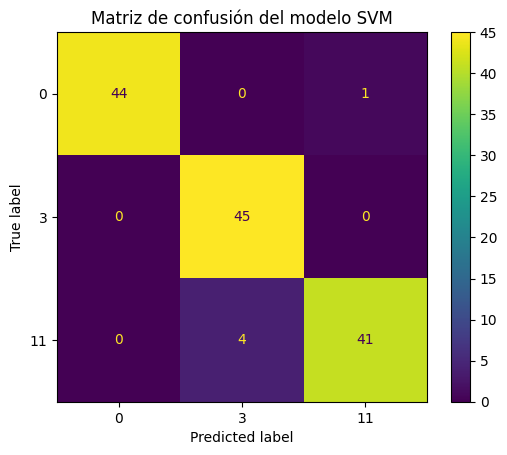

In [20]:

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_selected, y_test)
plt.title("Matriz de confusión del modelo SVM")
plt.show()

# 5. Evaluar el Mejor Modelo en el Conjunto de Prueba
Finalmente, evaluaremos el desempeño del modelo seleccionado en el conjunto de prueba.

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Entrenar el modelo con los mejores parámetros obtenidos
best_svm.fit(X_train_selected, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_svm.predict(X_test_selected)

# Evaluar la precisión en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en el conjunto de prueba: {accuracy}")

# Imprimir un reporte de clasificación más detallado (precision, recall, f1-score)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión en el conjunto de prueba: 0.9629629629629629
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           3       0.92      1.00      0.96        45
          11       0.98      0.91      0.94        45

    accuracy                           0.96       135
   macro avg       0.96      0.96      0.96       135
weighted avg       0.96      0.96      0.96       135



# END